In [1]:
import jax
import jax.numpy as jnp
from jax import random, grad, jit, jacfwd, jacrev
from jax.scipy.linalg import inv, svd, eigh, det
from jax.lax import scan
from scipy.linalg import solve_discrete_are, norm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from jax.tree_util import Partial
from functools import partial
from jax_vi import KL_gaussian, log_likelihood, KL_sum, plot_optimization_results, plot_k_matrices

from jax_filters import apply_filtering_fixed_nonlinear, kalman_filter_process, filter_step_nonlinear
from jax_models import visualize_observations, Lorenz96, KuramotoSivashinsky, generate_true_states, generate_localization_matrix

key = random.PRNGKey(3)

# System dimensions
n = 40  # System dimension
p = 2  # Observation dimension
J0 = 0 # burn in period
N = 10 # Monte Carlo samples for cost function sampling
F = 8.0
dt = 0.05
num_steps = 1000  # Number of time steps

# Model parameters
m0 = jnp.ones((n,))
C0 = jnp.eye(n) * 1.0   # Initial state covariance matrix (P)
Q = jnp.eye(n)* 0.1   # Process noise covariance matrix (Sigma in Julia code). We use diagonal for nonlinear case
H = jnp.eye(n)          # Observation noise matrix 
R = jnp.eye(H.shape[0])  # R is dependent on number of observed states (also written as Gamma)

observation_interval = 1

initial_state = random.normal(random.PRNGKey(0), (n,))  # Initial state
l96_model = Lorenz96(dt = dt, F = F)
state_transition_function = l96_model.step
l96_step = Partial(state_transition_function)

# Generate true states and observations using the Lorenz '96 model
key = random.PRNGKey(0)
jacobian_function = jacrev(l96_step, argnums=0)
jac_func = Partial(jacobian_function)


In [2]:
observations, true_states = generate_true_states(key, num_steps, n, initial_state, H, Q, R, l96_step, observation_interval)
y = observations

In [3]:
@partial(jit, static_argnums=(3,10))
def var_cost(K, m0, C0, n, H, Q, R, y, key, num_steps, J0):
    m_preds, C_preds, m_updates, C_updates = apply_filtering_fixed_nonlinear(m0, C0, y, K, n, l96_step, jac_func, H, Q, R)
    key, *subkeys = random.split(key, num=N+1)
    kl_sum = KL_sum(m_preds, C_preds, m_updates, C_updates, n, l96_step, Q, key)
    def inner_map(subkey):
        return log_likelihood(random.multivariate_normal(subkey, m_updates, C_updates), y, H, R, num_steps, J0) 
    cost = kl_sum - jnp.nanmean(jax.lax.map(inner_map, jnp.vstack(subkeys)))
    print(cost)
    return cost


@partial(jit, static_argnums=(3))
def var_cost_single_step(K, m0, C0, n, Q, H, R, y_curr, key, J, J0):

    _, (m_pred, C_pred, m_update, C_update)  =  filter_step_nonlinear((m0,C0,m0,C0), y_curr, K, n, l96_step, jac_func, H, Q, R)
    log_likelihood_val = log_likelihood(m_update[jnp.newaxis, :], y_curr[jnp.newaxis, :], H, R, J=1, J0=J0)
    kl_divergence = KL_gaussian(n, m_update, C_update, m_pred, C_pred)
    # Combine the KL divergence and the negative log-likelihood to form the cost
    cost = kl_divergence - log_likelihood_val
    return cost


In [4]:
base_m, base_C, base_K = kalman_filter_process(l96_step, jac_func, m0, C0, observations, H, Q, R)
K_steady = jnp.mean(base_K[-50:, :, :], axis=0)

In [9]:
import pickle
true_div = []
prediction_errors = [] 
norms = []
Ks = []
online = True

# Define the gradient of the cost function
var_cost_single_grad = grad(var_cost_single_step, argnums = 0)

# Initial guess for K and optimization parameters
alpha = 1e-5
K_opt = jnp.eye(n) * 0.4

for i in tqdm(range(num_steps)):
    key, _ = random.split(key)
    y_curr = observations[i] 
    for j in range(100):
        grad_K = var_cost_single_grad(K_opt, m0, C0, n, Q, H, R, y_curr, key, num_steps, J0)
        K_opt -= alpha * grad_K
    Ks.append(K_opt)
    norms.append(jnp.linalg.norm(K_opt - K_steady)) 
    (m_pred, C_pred, m_update, C_update), _ = filter_step_nonlinear((m0, C0, m0, C0), y_curr, K_opt, n, l96_step, jac_func, H, Q, R)
    prediction_error = jnp.square(m_update - true_states[i]).mean()  # Assuming true_states[i] is available
    prediction_errors.append(prediction_error)
    true_div.append(KL_gaussian(n, m_update, C_update, base_m[i], base_C[i]))
    m0, C0 = m_update, C_update


data = {
    'norms': norms,
    'prediction_errors': prediction_errors,
    'true_div': true_div,
    'n_iters': num_steps,
    'K_steady': K_steady,
    'K_opt': K_opt
}
with open('fixed_nonlinear_online', 'wb') as f:
    pickle.dump(data, f)

  0%|          | 0/1000 [00:00<?, ?it/s]

NameError: name 'n_iters' is not defined

In [6]:
# classic_kf_prediction_errors = jnp.mean(jnp.square(base_m - true_states), axis=1)

# print("Classic KF Prediction MSE (last 200 steps):", jnp.mean(classic_kf_prediction_errors[-200:]))
# print("Online Gradient Descent KF Prediction MSE (last 200 steps):", jnp.mean(jnp.array(prediction_errors[-200:])))


Classic KF Prediction MSE (last 200 steps): 0.2664159
Online Gradient Descent KF Prediction MSE (last 200 steps): 0.30114514


In [10]:
data = {
    'norms': norms,
    'prediction_errors': prediction_errors,
    'true_div': true_div,
    'n_iters': num_steps,
    'K_steady': K_steady,
    'K_opt': K_opt
}
with open('fixed_nonlinear_online', 'wb') as f:
    pickle.dump(data, f)

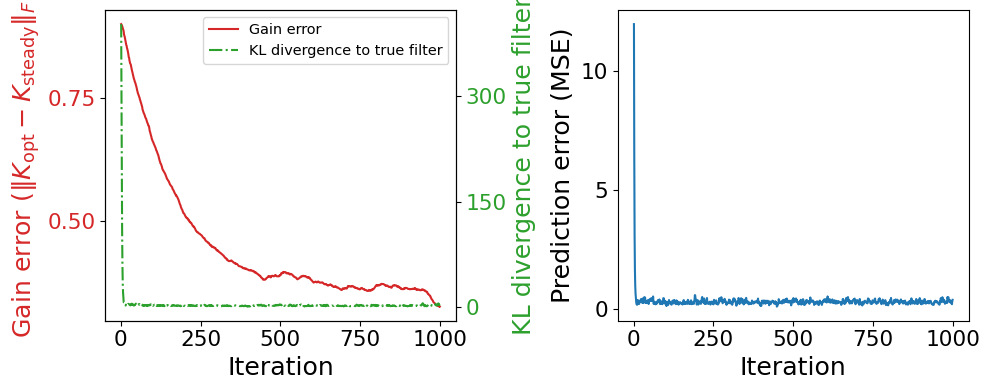

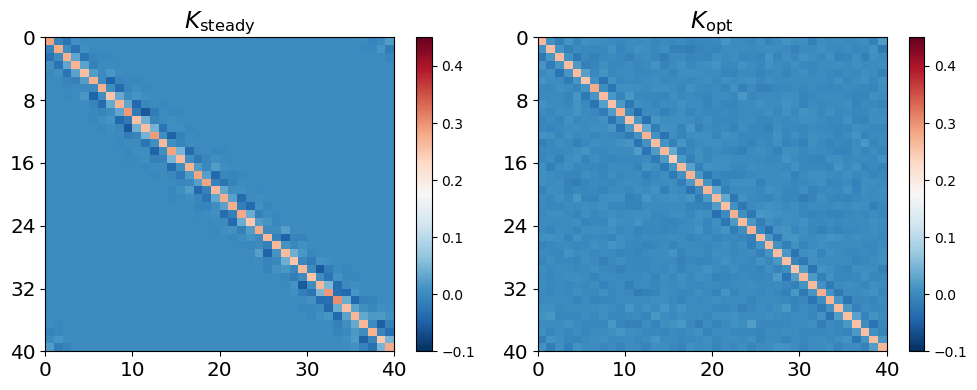

In [3]:
import pickle
with open('fixed_nonlinear_online', 'rb') as f:
    data = pickle.load(f)

online = True

norms = data['norms']
prediction_errors = data['prediction_errors']
true_div = data['true_div']
n_iters = data['n_iters']
num_steps = n_iters
K_steady = data['K_steady']
K_opt = data['K_opt']
import os
from jax_vi import plot_optimization_results, plot_k_matrices

subfolder_name = 'nonlinear_results'
file_base_name = "nonlinear_gain"

if online:
    n_iters = num_steps
    file_base_name += "_online"
file_name = file_base_name + ".pdf"
file_path = os.path.join(subfolder_name, file_name)

plot_optimization_results(norms, prediction_errors, true_div, n_iters, file_path, scaling=1.3, max_n_locator=3)

file_base_name = "nonlinear_gain_matrices"
if online:
    file_base_name += "_online"
file_name = file_base_name + ".pdf"
file_path = os.path.join(subfolder_name, file_name)
plot_k_matrices(K_steady, K_opt, file_path, scaling=1.2, max_n_locator=5)

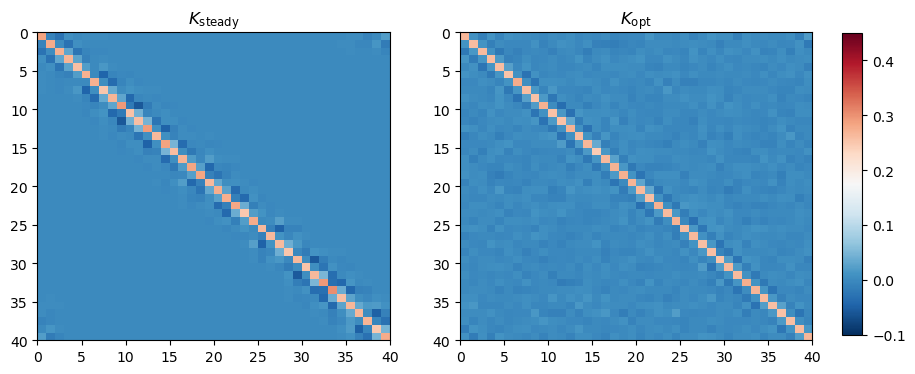

In [13]:
file_base_name = "nonlinear_gain_matrices"
if online:
    file_base_name += "_online"
file_name = file_base_name + ".pdf"
file_path = os.path.join(subfolder_name, file_name)
plot_k_matrices(K_steady, K_opt, file_path)

In [14]:
online

True